# OBLIGATORIO 2 - BIG DATA SCIENCE

## DATA PREPARATION

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql import SQLContext
from scipy import stats
import math
from IPython.display import Image 
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType, LongType, DoubleType, StringType
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark import keyword_only

### Problema 1 - Data Analysis en Pandas

Cargando los datos de ACMETelephoneABT.csv en un Dataframe en pandas:

In [5]:
path_to_file = '/home/jovyan/work/Big_Data_Course_UM/Obligatorio_II/ACMETelephoneABT.csv'
pd_df = pd.read_csv(path_to_file)
cols = pd_df.columns
trimed = []
for name in cols:
    trimed.append(name.strip())
pd_df.columns = trimed
pd.set_option('display.max_columns', 500)
pd_df.head()

,customer,age,occupation,regionType,marriageStatus,children,income,numHandsets,handsetAge,smartPhone,currentHandsetPrice,creditRating,homeOwner,creditCard,avgBill,avgMins,avgrecurringCharge,avgOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers,churn
0,1000004,26,crafts,town,yes,true,6,1,1812,false,0.00,C,true,true,38.00,7.50,38.00,0.00,0.00,-0.030,0.0000,0.41,0.33,0.00,0.362398,-6.330770,0.00,60,0.00,0,0,0,false
1,1000012,36,,,yes,true,9,4,544,true,79.99,A,false,true,35.30,24.25,34.98,0.00,0.00,0.395,-0.0062,2.39,4.00,1.67,5.586826,7.499560,0.00,53,0.00,0,0,0,false
2,1000034,74,professional,town,yes,false,7,2,138,true,29.99,A,false,true,21.15,45.50,16.99,14.00,0.00,-0.310,-0.0832,2.28,0.00,0.33,0.500000,-5.940493,4.33,58,0.00,0,0,3,false
3,1000063,30,,suburban,no,false,6,3,122,true,9.99,C,false,true,91.18,332.75,75.00,0.00,0.00,-0.615,-0.1084,33.21,9.00,4.67,8.629661,-0.066485,5.33,50,0.33,0,0,0,false
4,1000085,32,,town,yes,false,7,8,10,true,129.99,A,false,true,93.02,1348.25,75.00,4.75,1.92,-3.305,0.4930,436.53,59.33,23.00,14.042685,-7.208502,14.67,56,0.00,0,0,0,false


In [3]:
pd_df.occupation.unique()

array([' crafts', ' ', ' professional', ' homemaker', ' clerical',
       ' self-employed', ' retired', ' student'], dtype=object)

Se puede ver que datos contienen espacios en ellos y creditCard tiene booleans con muchos valores.

In [32]:
objcols =  pd_df.columns.to_series().groupby(pd_df.dtypes).groups
objcols = {k.name: v for k, v in objcols.items()}
objcols = list(objcols['object'])

pd_df[objcols] = pd_df[objcols].applymap(lambda x: x.strip())
pd_df.creditRating.unique()

array(['C', 'A', 'D', 'E', 'G', 'B', 'F'], dtype=object)

###### 1. Usando el método describe, crear un Data Quality Report.

In [8]:
pd_df.describe(include=[np.number])

,customer,age,income,numHandsets,handsetAge,currentHandsetPrice,avgBill,avgMins,avgrecurringCharge,avgOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.049974e+06,30.318400,4.293600,1.804500,390.171700,35.730696,58.927600,521.170645,46.236537,42.392670,1.186048,-0.280848,-0.003595,115.266619,25.208834,8.368029,2.217785,-0.046749,9.992283,18.836300,1.737414,0.044600,0.020700,0.195000
std,2.879841e+04,22.158676,3.139902,1.345088,257.076656,57.072922,43.889815,540.435285,23.964960,106.374374,6.048811,5.231031,0.762955,169.979443,35.665714,17.676847,3.882714,9.973846,14.859162,9.610928,5.754564,0.225867,0.155158,0.641261
min,1.000001e+06,0.000000,0.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.355000,-7.600400,0.000000,0.000000,0.000000,0.000000,-41.322736,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1.025200e+06,0.000000,0.000000,1.000000,210.000000,0.000000,33.327500,150.627500,30.000000,0.000000,0.000000,-1.725000,-0.132600,7.690000,3.000000,0.000000,0.779357,-6.791049,1.670000,11.000000,0.000000,0.000000,0.000000,0.000000
50%,1.049833e+06,34.000000,5.000000,1.000000,339.000000,0.000000,49.205000,359.625000,44.990000,3.000000,0.000000,-0.100000,-0.005200,52.540000,13.330000,2.000000,1.399874,0.011607,5.330000,17.000000,0.000000,0.000000,0.000000,0.000000
75%,1.074990e+06,48.000000,7.000000,2.000000,525.000000,59.990000,71.762500,709.187500,59.990000,43.750000,0.260000,1.300000,0.042600,154.382500,33.330000,9.000000,2.494232,6.494723,12.670000,24.000000,1.330000,0.000000,0.000000,0.000000
max,1.099988e+06,98.000000,9.000000,21.000000,1812.000000,499.990000,584.230000,6336.250000,337.980000,4320.750000,177.990000,50.425000,17.911400,2006.290000,610.330000,304.000000,160.000000,37.779743,304.670000,61.000000,365.670000,4.000000,4.000000,3.000000


In [64]:
pd_df.describe(include=[object])

,occupation,regionType,marriageStatus,children,smartPhone,creditRating,homeOwner,creditCard,churn
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,8,8,3,2,2,7,2,6,2
top,,,unknown,false,true,B,false,true,true
freq,7400,4776,3920,7559,9015,3785,6577,6537,5000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82b2b55a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f82b20497d0>]], dtype=object)

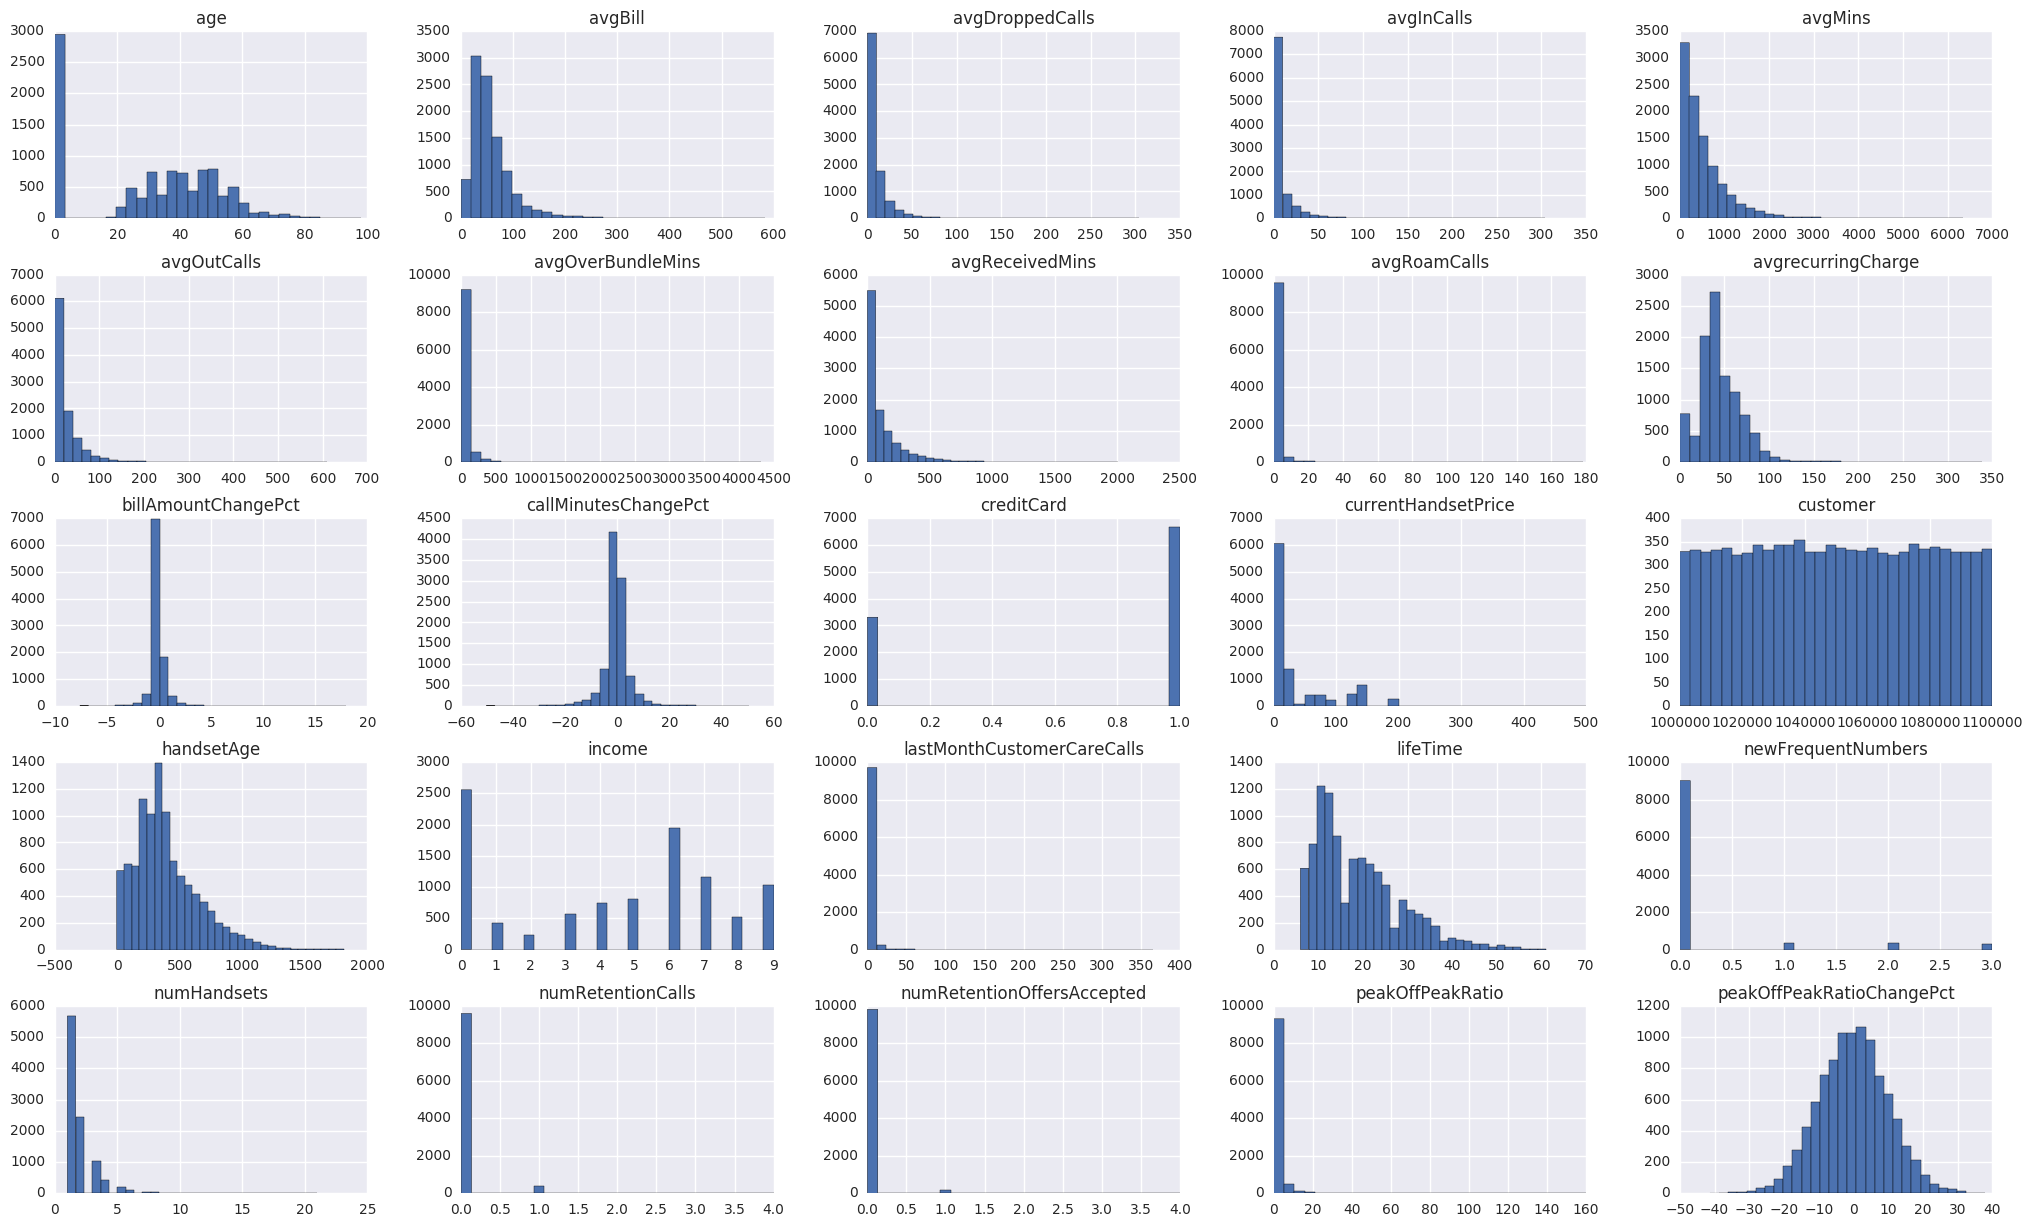

In [106]:
pd_df.hist(figsize=(25,15),bins=30)

Tanto age como income cuentan con valores = 0, que deberían ser null.
HandsetAge min = -5?

In [46]:
pd_df.churn.unique()

array(['false', 'true'], dtype=object)

occupation, regionType y marriageStatus tienen muchos valores missing que aparecen como '' o unknown

regionType tiene problema de cardinalidad.

todas las rows tienen el tarjet bien.

###### 2. Determinar para cada atributo su tipo (i.e. ordinal, categórico, etc)

In [50]:
pd_df.convert_objects
pd_df.dtypes

customer                        int64
age                             int64
occupation                     object
regionType                     object
marriageStatus                 object
children                       object
income                          int64
numHandsets                     int64
handsetAge                      int64
smartPhone                     object
currentHandsetPrice           float64
creditRating                   object
homeOwner                      object
creditCard                     object
avgBill                       float64
avgMins                       float64
avgrecurringCharge            float64
avgOverBundleMins             float64
avgRoamCalls                  float64
callMinutesChangePct          float64
billAmountChangePct           float64
avgReceivedMins               float64
avgOutCalls                   float64
avgInCalls                    float64
peakOffPeakRatio              float64
peakOffPeakRatioChangePct     float64
avgDroppedCa

Todos los int64 y float64 son numéricos.
Los que son object:
occupation                    Categorical
regionType                    Categorical
marriageStatus                Boolean
children                      Boolean
smartPhone                    Boolean
creditRating                  Ordinal
homeOwner                     Boolean
creditCard                    object
churn                         object

###### 3.Usando el método corr() de Pandas, identificar los 3 pares de atributos con mayor correlación (usar Pearson como métrica).

In [11]:
corr = pd_df.corr(method='pearson')

In [12]:
corr

,customer,age,income,numHandsets,handsetAge,currentHandsetPrice,creditCard,avgBill,avgMins,avgrecurringCharge,avgOverBundleMins,avgRoamCalls,callMinutesChangePct,billAmountChangePct,avgReceivedMins,avgOutCalls,avgInCalls,peakOffPeakRatio,peakOffPeakRatioChangePct,avgDroppedCalls,lifeTime,lastMonthCustomerCareCalls,numRetentionCalls,numRetentionOffersAccepted,newFrequentNumbers
customer,1.000000,-0.117682,-0.134630,-0.261656,-0.419970,-0.030507,-0.133329,0.006476,0.094690,0.060883,-0.002703,0.015770,-0.004407,-0.001350,0.054830,0.046272,0.038587,-0.123676,-0.001946,0.068565,-0.752537,0.092704,-0.058963,-0.045458,-0.008781
age,-0.117682,1.000000,0.665303,-0.012326,0.120619,-0.044271,0.679897,-0.099618,-0.141152,-0.110412,-0.046321,-0.029106,0.008715,-0.009873,-0.121843,-0.126774,-0.099762,0.041059,-0.000112,-0.088091,0.123912,-0.062742,-0.011150,-0.007270,0.003724
income,-0.134630,0.665303,1.000000,-0.026427,0.134935,-0.041015,0.696205,-0.085928,-0.142944,-0.084591,-0.045467,-0.024151,0.002837,-0.019343,-0.126500,-0.111885,-0.104544,0.065670,-0.000509,-0.100520,0.138451,-0.090742,-0.012825,-0.004060,0.011945
numHandsets,-0.261656,-0.012326,-0.026427,1.000000,-0.359943,0.542411,0.003079,0.258255,0.303252,0.240720,0.162580,0.014863,-0.028437,-0.011218,0.274293,0.257173,0.259905,0.008845,-0.010108,0.213288,0.363029,0.094164,0.111986,0.097503,0.020085
handsetAge,-0.419970,0.120619,0.134935,-0.359943,1.000000,-0.428018,0.108723,-0.241876,-0.323110,-0.264443,-0.130113,-0.037326,-0.006513,-0.011473,-0.259274,-0.245505,-0.207028,0.108937,-0.004046,-0.233402,0.481136,-0.144866,-0.029746,-0.031145,-0.010463
currentHandsetPrice,-0.030507,-0.044271,-0.041015,0.542411,-0.428018,1.000000,-0.020277,0.238746,0.281855,0.223835,0.136505,0.011553,0.002259,0.007433,0.251663,0.253109,0.228867,-0.032385,-0.004159,0.186527,0.036979,0.098189,0.073014,0.068240,0.003733
creditCard,-0.133329,0.679897,0.696205,0.003079,0.108723,-0.020277,1.000000,-0.076384,-0.111994,-0.086874,-0.033220,-0.034039,0.021343,-0.001829,-0.092043,-0.094678,-0.069331,0.034818,-0.006633,-0.075295,0.128382,-0.056697,-0.000478,-0.003487,0.009900
avgBill,0.006476,-0.099618,-0.085928,0.258255,-0.241876,0.238746,-0.076384,1.000000,0.727535,0.631075,0.780485,0.244663,-0.020326,0.012216,0.625518,0.517503,0.416616,0.000308,-0.003148,0.445601,-0.018345,0.142319,0.017435,0.010886,-0.003987
avgMins,0.094690,-0.141152,-0.142944,0.303252,-0.323110,0.281855,-0.111994,0.727535,1.000000,0.575358,0.581635,0.117649,-0.051441,-0.016847,0.835479,0.707246,0.590484,-0.084473,0.005397,0.581539,-0.083280,0.308847,0.010349,0.009802,0.003470
avgrecurringCharge,0.060883,-0.110412,-0.084591,0.240720,-0.264443,0.223835,-0.086874,0.631075,0.575358,1.000000,0.187628,0.069146,-0.027488,-0.017510,0.472973,0.407312,0.324194,0.011824,-0.007505,0.326137,-0.066327,0.118531,-0.020771,-0.003877,-0.002368


In [13]:
type(corr)

pandas.core.frame.DataFrame

In [14]:
a = corr.abs()

list_abs = a.unstack()
list_abs.sort_values(inplace=True)

In [15]:
tot = len(list_abs)
list_abs[-34:-24]

numRetentionCalls  numRetentionOffersAccepted    0.718484
avgMins            avgBill                       0.727535
avgBill            avgMins                       0.727535
lifeTime           customer                      0.752537
customer           lifeTime                      0.752537
avgBill            avgOverBundleMins             0.780485
avgOverBundleMins  avgBill                       0.780485
avgReceivedMins    avgMins                       0.835479
avgMins            avgReceivedMins               0.835479
customer           customer                      1.000000
dtype: float64

Max correlation pairs:
customer                    lifeTime                      0.752537
avgOverBundleMins           avgBill                       0.780485
avgReceivedMins             avgMins                       0.835479

##### 4. Para estos 3 pares de atributos, crear una gráfica de correlación y distribución usando el paquete seaborn.

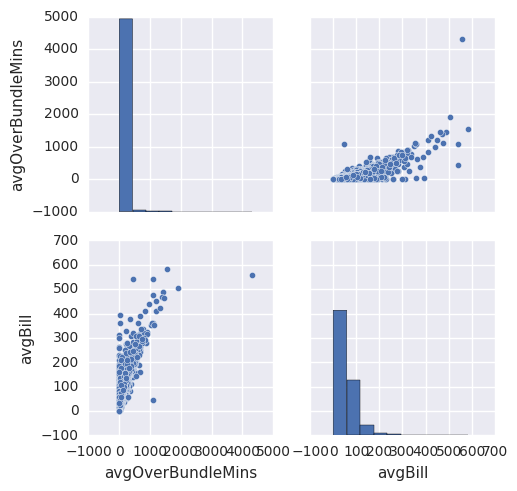

In [79]:
sns.pairplot(pd_df[["avgReceivedMins", "avgMins"]])

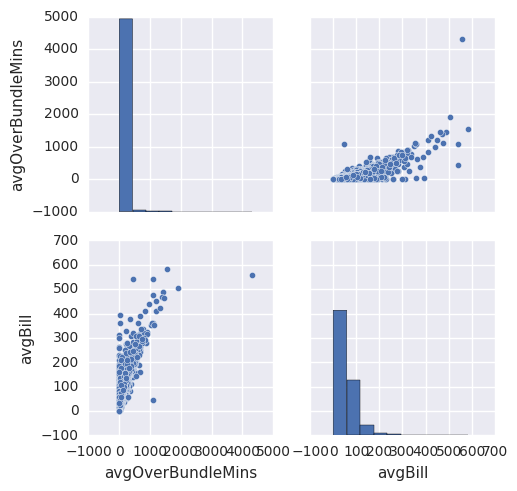

In [79]:
sns.pairplot(pd_df[["avgOverBundleMins", "avgBill"]])

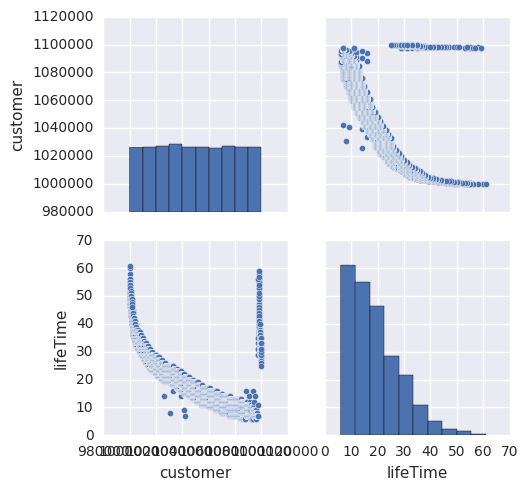

In [80]:
sns.pairplot(pd_df[["customer", "lifeTime"]])

##### 5. Crear boxplots para los atributos lifeTime, age (en la misma gráfica). Solamente mirando estas gráficas escriba todas las conclusiones que uno puede sacar de estos datos.

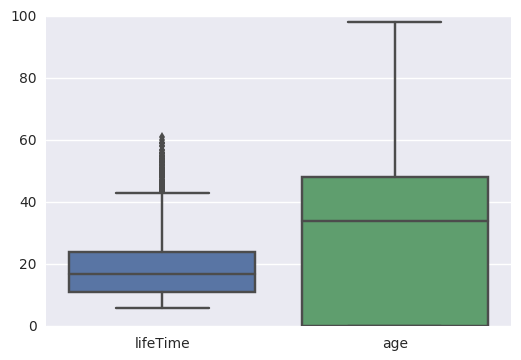

In [97]:
sns.boxplot(data=pd_df[["lifeTime","age"]])

LifeTime:
Range ~= 61 - 6 = 55
Min ~= 6    Max~=61
Quartiles:
1: 6-12
2: 13-16
3: 17-22
4: 23-41
Outliers:
41-61
Media ~= 16


age:
Range ~= 98 - 0 = 98
Min ~= 0    Max~=98
Quartiles:
1: 0-0
2: 0-34
3: 35-44
4: 45-98
Media ~= 34

Podemos ver que hay >= del 25% de las edades con valor 0, seguramente este valor signifique que no se ingresó la misma.

##### 6. Crear gráficas de densidad (KDE) para los atributos avgMins y avgOutCalls (con y sin usar escala logarítmica) ¿Qué distribución cree usted que sigue av-gOutCalls ?

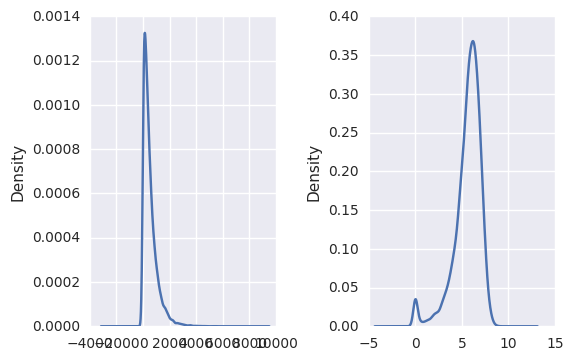

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5);

pd_df["avgMins"].plot(kind = "kde", ax=axes[0]);

(pd_df.avgMins + 1).apply(math.log).plot(kind = "kde", ax=axes[1]);

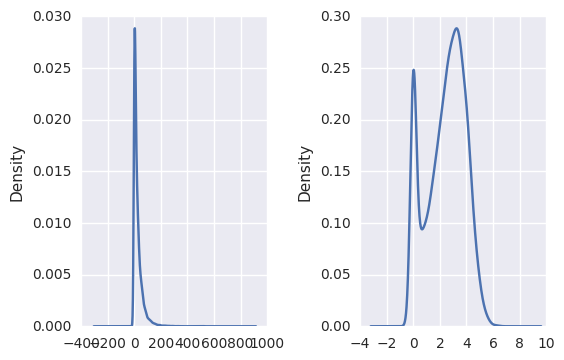

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5);

pd_df["avgOutCalls"].plot(kind = "kde", ax=axes[0]);

(pd_df.avgOutCalls + 1).apply(math.log).plot(kind = "kde", ax=axes[1]);

AvgOutCalls tiene una distribución normal multimodal.

##### 7. Utilizando avgMins y avgOutCalls:

a) Normalizar usando como valor máximo 2 desviaciones estándar de la media en nuevas columnas. Guardar los resultado en nuevas columna, avgMinsNorm y avgOutCallsNorm.

In [21]:
desc = pd_df[["avgMins","avgOutCalls"]].describe(include=[np.number])
desc

,avgMins,avgOutCalls
count,10000.000000,10000.000000
mean,521.170645,25.208834
std,540.435285,35.665714
min,0.000000,0.000000
25%,150.627500,3.000000
50%,359.625000,13.330000
75%,709.187500,33.330000
max,6336.250000,610.330000


In [22]:
def norm_2_std(value, min_val, std, mean):
    return float(value)/(mean + 2*std - min_val)

In [23]:
pd_df["avgMinsNorm"] = pd_df["avgMins"].apply(lambda x: norm_2_std(x, desc.avgMins['min'], desc.avgMins['std'], desc.avgMins['mean']))
pd_df["avgOutCallsNorm"] = pd_df["avgOutCalls"].apply(lambda x: norm_2_std(x, desc.avgOutCalls['min'], desc.avgOutCalls['std'], desc.avgOutCalls['mean']))

In [24]:
pd_df[["avgMins", "avgMinsNorm", "avgOutCalls", "avgOutCallsNorm"]].head()

,avgMins,avgMinsNorm,avgOutCalls,avgOutCallsNorm
0,7.50,0.004682,0.33,0.003418
1,24.25,0.015137,4.00,0.041433
2,45.50,0.028401,0.00,0.000000
3,332.75,0.207704,9.00,0.093225
4,1348.25,0.841583,59.33,0.614562


b) Graficar los histogramas de estas distribuciones.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82c840d6d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f82c840f9d0>]], dtype=object)

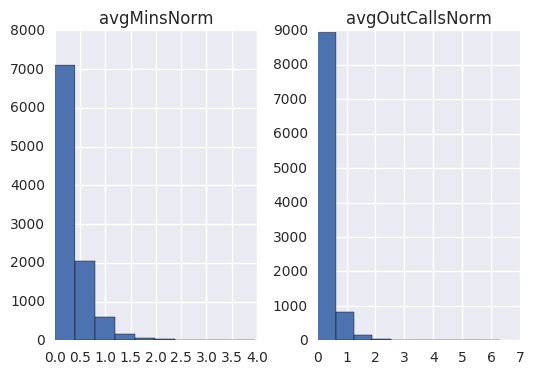

In [25]:
pd_df[["avgMinsNorm", "avgOutCallsNorm"]].hist()

c) Investigar sobre la estadística de kolmogorov-smirnov y determinar si estos valores siguen una misma distribución.

In [26]:
stats.ks_2samp(pd_df["avgMinsNorm"], pd_df["avgOutCallsNorm"])

Ks_2sampResult(statistic=0.16959999999999997, pvalue=8.9126772886164236e-126)

Debido a que pvalue ~= 0, podemos asegurar que las muestras no provienen de la misma distribución.

d) Usando la función apply() de pandas, discretizar la columna avgMins en 5

bins distintos usando:

1) igual frecuencia.

In [163]:
pd_df["avgMins_disc_f"] = pd.qcut(pd_df["avgMins"].tolist(),5)
pd_df[["avgMins","avgMins_disc_f"]].head()

,avgMins,avgMins_disc_f
0,7.50,"[0, 116]"
1,24.25,"[0, 116]"
2,45.50,"[0, 116]"
3,332.75,"(269.65, 474.25]"
4,1348.25,"(827.1, 6336.25]"


2) igual ancho.

In [164]:
pd_df["avgMins_disc_w"] = pd.cut(pd_df["avgMins"].tolist(),5)
pd_df[["avgMins","avgMins_disc_w"]].head()

,avgMins,avgMins_disc_w
0,7.50,"(-6.336, 1267.25]"
1,24.25,"(-6.336, 1267.25]"
2,45.50,"(-6.336, 1267.25]"
3,332.75,"(-6.336, 1267.25]"
4,1348.25,"(1267.25, 2534.5]"


##### 8. Crear una muestra del dataset entero para reducir el tamaño a un 20 % usando:

a) muestra aleatoria.


In [169]:
df_random_sample = pd_df.sample(frac=0.2)
df_random_sample.shape

(2000, 37)

##### 9. Formular un test de hipótesis para determinar si personas sin smartPhone son más proclives a abandonar el contrato (churn) que los que los que tienen smartPhone. Usar p=0.01.

Se debe realizar la hipótesis nula:

Ho: personas sin smartPhone no son más proclives a abandonar el contrato.

In [91]:
smart_num = [1 if x == 'true' else 0 for x in pd_df.smartPhone.values]
churn_num = [1 if x == 'true' else 0 for x in pd_df.churn.values]
stats.ttest_ind(smart_num,churn_num)

Ttest_indResult(statistic=68.975296347964445, pvalue=0.0)

In [100]:
pd_df.smartPhone.values

array(['false', 'true', 'true', ..., 'true', 'true', 'true'], dtype=object)

##### 10. Analizar y limpiar los datos para la columna: creditCard.

In [21]:
pd_df.creditCard.unique()

array([' true', ' false', ' no', ' t', ' f', ' yes'], dtype=object)

In [25]:
def various_to_TF(various):
    res = -1
    if various.strip().lower() in ['true', 't', 'yes', 'y']:
        res = True
    else:
        res = False
    return res

In [26]:
pd_df['creditCard'] = pd_df['creditCard'].apply(various_to_TF)
pd_df.creditCard.unique()

array([True, False], dtype=object)

In [18]:
pd_df[['creditCard']]

,creditCard
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


##### 11. Formular un test de hipótesis para determinar si personas con creditCard son más proclives a abandonar el contrato (churn) que los que los que tienen smartPhone. Usar p=0.01.

In [98]:
credit_num = [1 if x == True else 0 for x in pd_df.creditCard.values]
churn_num = [1 if x == 'true' else 0 for x in pd_df.churn.values]
stats.ttest_ind(credit_num,churn_num)

Ttest_indResult(statistic=24.658646840146805, pvalue=2.7999694913070107e-132)

### Problema 2 - Análisis del reporte de la calidad de datos

Ej 9. Cap 3 FML

“9. Tachycardia is a condition that causes the heart to beat faster than normal at rest. The occurrence of tachycardia can have serious implications including increased risk of stroke or sudden cardiac arrest. An analytics consultant has been hired by a major hospital to build a predictive model that predicts the likelihood that a patient at a heart disease clinic will suffer from tachycardia in the month following a visit to the clinic. The hospital will use this model to make predictions for each patient when they visit the clinic and offer increased monitoring for those deemed to be at risk. The analytics consultant has generated an ABT to be used to train this model.
The descriptive features in this dataset are defined as follows:

AGE: The patient’s age

GENDER: The patient’s gender (male or female)

WEIGHT: The patient’s weight

HEIGHT: The patient’s height

BMI: The patient’s body mass index (BMI) which is calculated as  where weight is measured in kilograms and height in meters.

SYS. B.P.: The patient’s systolic blood pressure

DIA. B.P.: The patient’s diastolic blood pressure

HEART RATE: The patient’s heart rate

H.R. DIFF.: The difference between the patient’s heart rate at this visit and at their last visit to the clinic

PREV. TACHY.: Has the patient suffered from tachycardia before?

TACHYCARDIA: Is the patient at high risk of suffering from tachycardia in the next month?

The following table contains an extract from this ABT—the full ABT contains 2,440 instances.” 

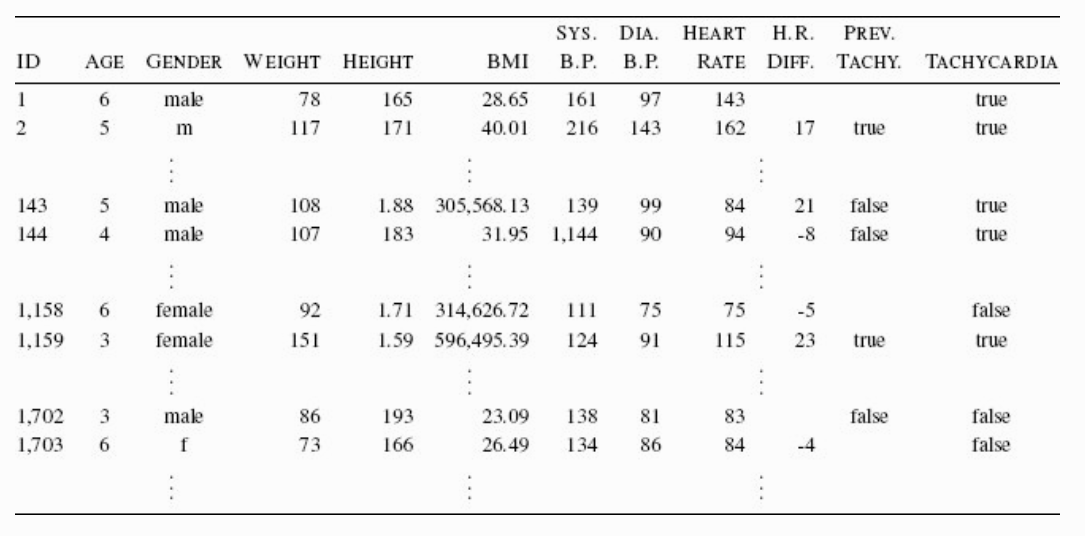

In [37]:
Image('/home/jovyan/work/Big_Data_Course_UM/Obligatorio_II/ABT.png', format='png')

“The consultant generated the following data quality report from the ABT.” 

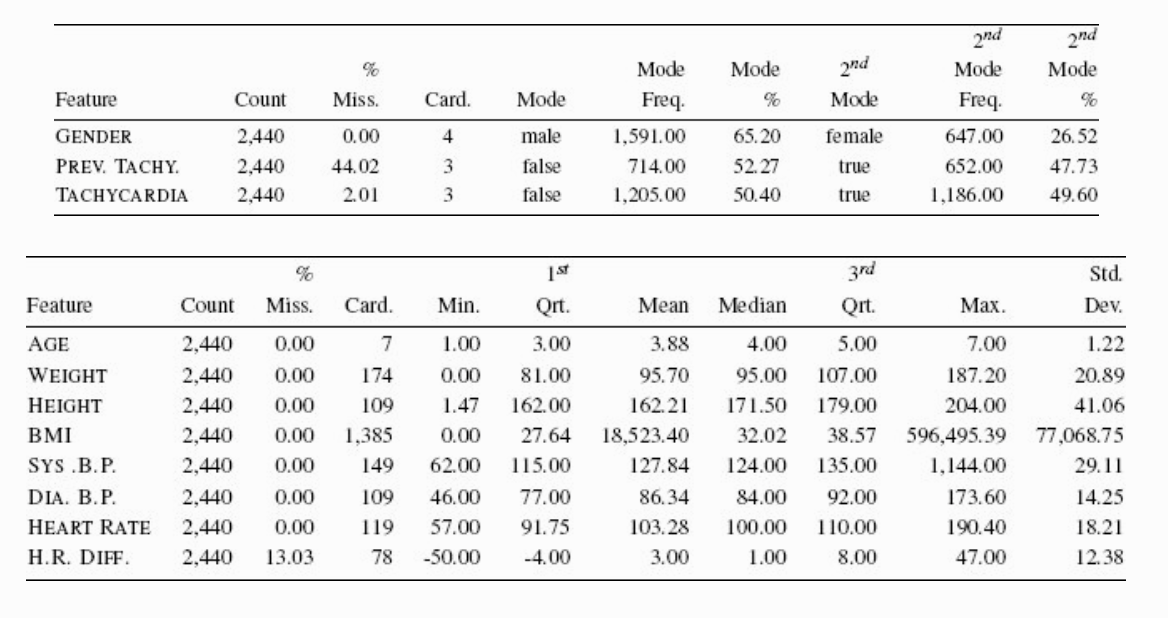

In [38]:
Image('/home/jovyan/work/Big_Data_Course_UM/Obligatorio_II/DQR.png', format='png')

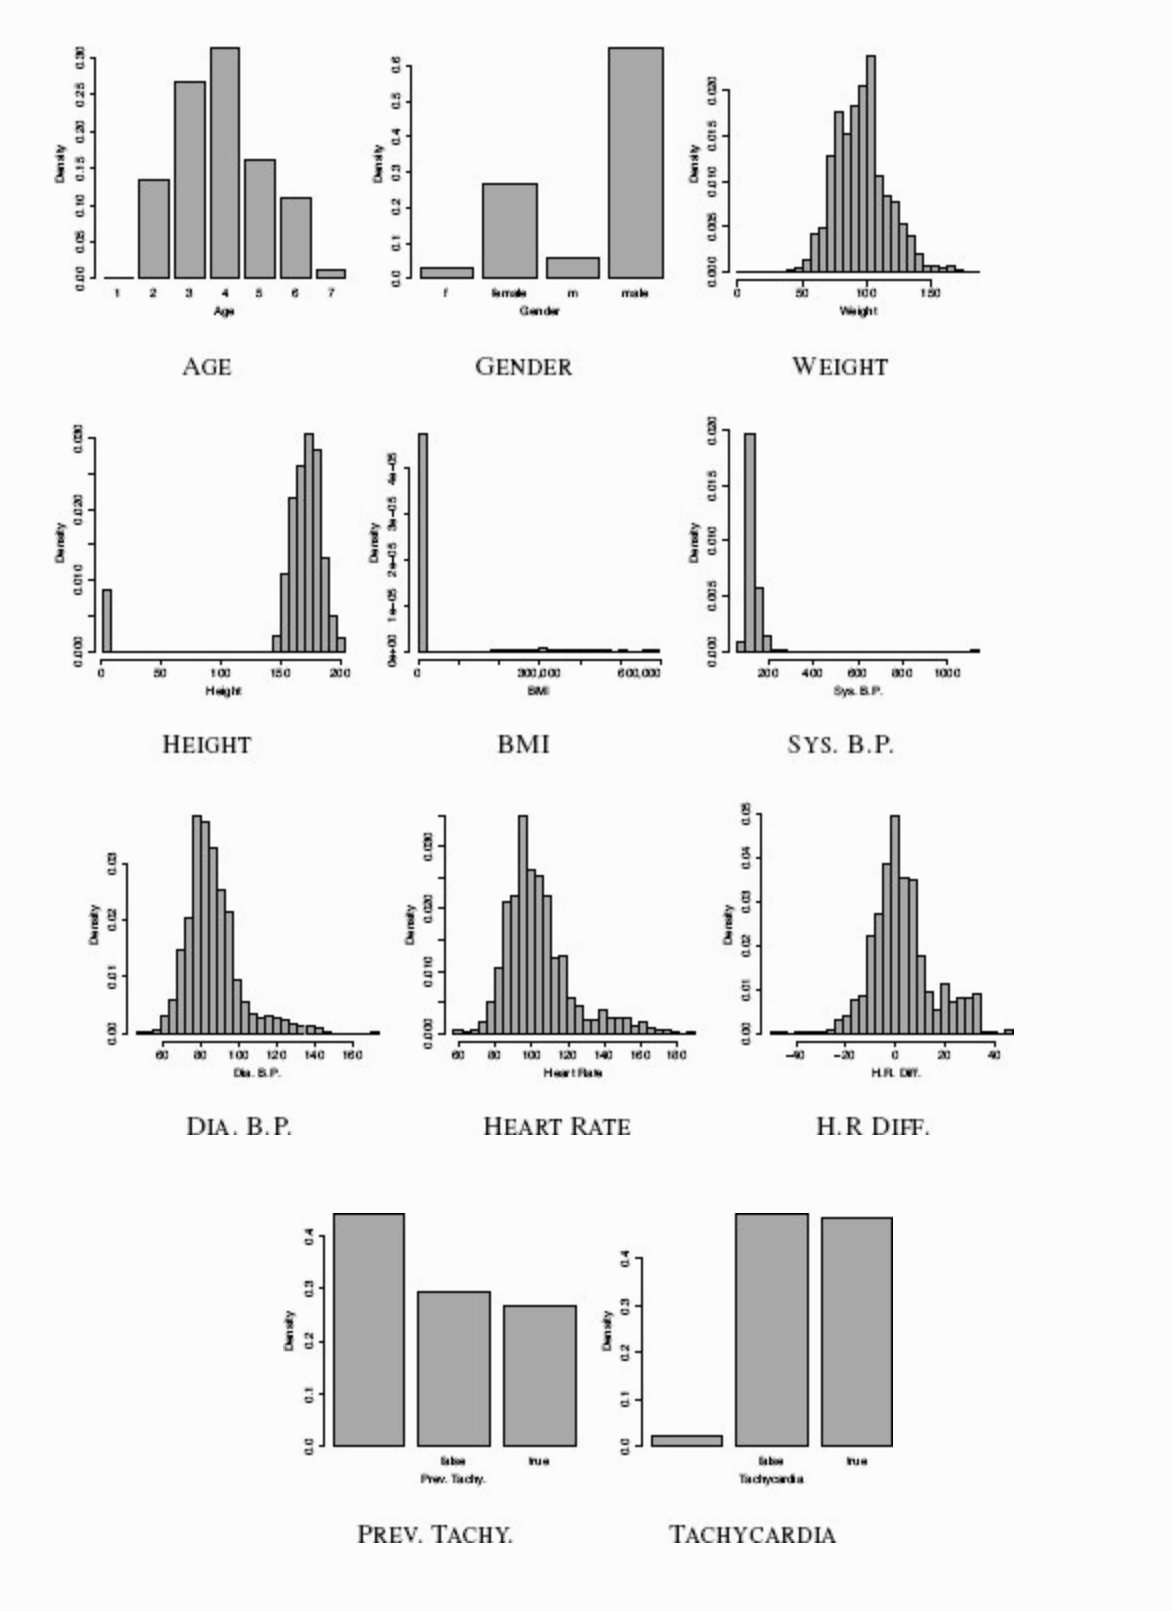

In [40]:
Image('/home/jovyan/work/Big_Data_Course_UM/Obligatorio_II/Charts.png', format='png')

“Discuss this data quality report in terms of the following:

a. Missing values

b. Irregular cardinality

c. Outliers

d. Feature distributions”

Fragmento de: John D. Kelleher. “Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies”. iBooks. 

##### a. Missing values

Vemos que las features con missing values son:

Prev. Tachy. - 44.02%

Tachycardia - 2.01%

H.R. Fidd. - 13.03%

Ninguno de ellos supera el 60% por lo que eliminar cualquiera de ellos sería una estrategia demasiado agresiva.

El caso de H.R. Fidd tiene un porcentaje de missing values razonable para aplicar imputation con una estrategia sencilla, como insertar la media en los missing values.

En el caso de Prev. Tachy. se puede utilizar imputation o agregar una flag que indique si este valor era faltante, ya que esto puede estar ligado a tener otro ataque en el futuro, en un principio y ver los resultados, sabiendo que si no son muy exitosos se podría considerar un aproach más avanzado como construir un modelo para predecir los valores faltantes.

Por otro lado, como el feature Tachycardia es el tarjet feature, se deben eliminar las filas donde esta característica sea faltante ya que estaríamos entrenando el modelo con casos ficticios que pueden no representar la realidad.

##### b. Irregular cardinality

El único caso de irregularidad de cardinalidad observada es la de Gender, ya que al observar los valores que toma se ve que son ['f','female','m','male'], por lo que se deberán mapear a [('f','female') -> 'female', ('m','male') -> 'male']

##### c. Outliers

Se detectaron valores del tipo outlier en las categorías: Height, BMI, Sys. B.P., aunque como BMI es probablemente calculado a partir de Height, parte de los outliers de BMI se deban a los outliers de Height, ambas categorías cuentan con outliers de valor 0, lo que se interpreta como que son missing values, por lo que se recomienda borrar estos valores y hacer un análisis del porcentaje que representan y elegir como afrontar el problema dependiendo de esto.

##### d. Feature distributions

### Problema 3 - Preparación de datos en Spark

Cargar el dataset (ACMETelephoneABT.csv) en un Dataframe de Spark. Usando

Spark Pipelines, limpiar los atributos: avgDroppedCalls, creditCard, handsetAge,

marriageStatus, numHandsets, regionType forma que todos ellos sean numéricos

y normalizados. Utilizar one hot encoding para transformar atributos categóricos en

numéricos.

In [2]:
sc = pyspark.SparkContext(master='local[*]')

In [3]:
sqlContext = SQLContext(sc)

In [6]:
raw_data_rdd = sc.textFile(path_to_file).map(lambda x: [y.strip() for y in x.split(',')])

In [7]:
raw_data_rdd.take(1)

[[u'customer',
  u'age',
  u'occupation',
  u'regionType',
  u'marriageStatus',
  u'children',
  u'income',
  u'numHandsets',
  u'handsetAge',
  u'smartPhone',
  u'currentHandsetPrice',
  u'creditRating',
  u'homeOwner',
  u'creditCard',
  u'avgBill',
  u'avgMins',
  u'avgrecurringCharge',
  u'avgOverBundleMins',
  u'avgRoamCalls',
  u'callMinutesChangePct',
  u'billAmountChangePct',
  u'avgReceivedMins',
  u'avgOutCalls',
  u'avgInCalls',
  u'peakOffPeakRatio',
  u'peakOffPeakRatioChangePct',
  u'avgDroppedCalls',
  u'lifeTime',
  u'lastMonthCustomerCareCalls',
  u'numRetentionCalls',
  u'numRetentionOffersAccepted',
  u'newFrequentNumbers',
  u'churn']]

In [ ]:
customer                        int64
age                             int64
occupation                     object
regionType                     object
marriageStatus                 object
children                       object
income                          int64
numHandsets                     int64
handsetAge                      int64
smartPhone                     object
currentHandsetPrice           float64    10
creditRating                   object
homeOwner                      object
creditCard                     object
avgBill                       float64
avgMins                       float64
avgrecurringCharge            float64
avgOverBundleMins             float64
avgRoamCalls                  float64
callMinutesChangePct          float64
billAmountChangePct           float64    20
avgReceivedMins               float64
avgOutCalls                   float64
avgInCalls                    float64
peakOffPeakRatio              float64
peakOffPeakRatioChangePct     float64
avgDroppedCalls               float64    26
lifeTime                        int64
lastMonthCustomerCareCalls    float64    28
numRetentionCalls               int64
numRetentionOffersAccepted      int64
newFrequentNumbers              int64
churn                          object    32

In [8]:
header = raw_data_rdd.first()
raw_data_df = raw_data_rdd.filter(lambda row : row != header).map(lambda x: [int(x[0]),int(x[1]),x[2],x[3],x[4],x[5],int(x[6]),int(x[7]),int(x[8]),x[9],float(x[10]),x[11],x[12],x[13],float(x[14]),float(x[15]),float(x[16]),float(x[17]),float(x[18]),float(x[19]),float(x[20]),float(x[21]),float(x[22]),float(x[23]),float(x[24]),float(x[25]),float(x[26]),int(x[27]),float(x[28]),int(x[29]),int(x[30]),int(x[31]),x[32]]).toDF(header)

In [51]:
raw_data_df.approxQuantile(0.23,)

pyspark.sql.dataframe.DataFrame

Boxplots

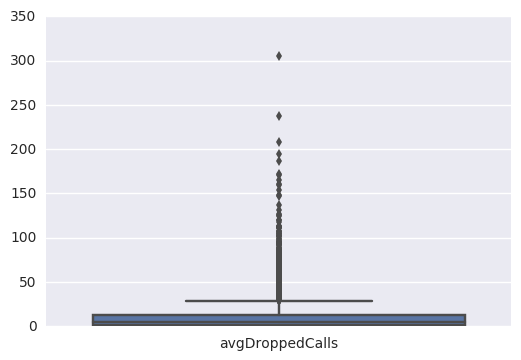

In [7]:
sns.boxplot(data=pd_df[["avgDroppedCalls"]])

In [210]:
class corr_Outliers(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, minfix=None):
        super(corr_Outliers, self).__init__()
        self.minfix = Param(self, "minfix", "")
        self._setDefault(minfix="No")
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None, minfix=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
    
    def setMinFix(self, value):
        self._paramMap[self.minfix] = value
        return self

    def getMinFix(self):
        return self.getOrDefault(self.minfix)
        
    def _transform(self, dataset):
        input_col = dataset[self.getInputCol()]
        [fst_quart , thrd_quart] = dataset.approxQuantile(self.getInputCol(),[0.25,0.75],0)
        out_col = self.getOutputCol()
        minfix = self.getMinFix()
        udf = UserDefinedFunction(lambda x: manage_outliers(x, fst_quart , thrd_quart, minfix), DoubleType())
        return dataset.withColumn(out_col, udf(input_col))

def manage_outliers(input_c, fst_quart , thrd_quart, fixmin):
    dif_quart = thrd_quart - fst_quart
    min_tresh = fst_quart - 1.5 * dif_quart
    max_tresh = thrd_quart + 1.5 * dif_quart
    if type(fixmin) != str:
        min_tresh = fixmin
    res = 0.0
    if (input_c > min_tresh) and (input_c < max_tresh):
        res = float(input_c)
    elif input_c <= min_tresh:
        res = float(min_tresh)
    elif input_c >= max_tresh:
        res = float(max_tresh)
    return res
            

In [199]:
type("No") != str

False

In [211]:
avgDropp_Outliers_transformer = corr_Outliers(inputCol='avgDroppedCalls', outputCol='avgDroppedCallsNoOut')
pipeline_1 = Pipeline(stages=[avgDropp_Outliers_transformer])
model = pipeline_1.fit(raw_data_df)
newmodel = model.transform(raw_data_df)

In [212]:
newmodel.describe("avgDroppedCallsNoOut").show()

+-------+--------------------+
|summary|avgDroppedCallsNoOut|
+-------+--------------------+
|  count|               10000|
|   mean|   8.496305999999924|
| stddev|     8.7442719996375|
|    min|                 0.0|
|    max|               29.17|
+-------+--------------------+



In [213]:
newmodel.describe("avgDroppedCalls").show()

+-------+-----------------+
|summary|  avgDroppedCalls|
+-------+-----------------+
|  count|            10000|
|   mean|9.992283000000013|
| stddev|14.85916237708458|
|    min|              0.0|
|    max|           304.67|
+-------+-----------------+



Credit card

In [75]:
class corr_True_False(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(corr_True_False, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        input_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: map_T_F(x), StringType())
        return dataset.withColumn(out_col, udf(input_col))

def map_T_F(various):
    res = ''
    if various.strip().lower() in ['true', 't', 'yes', 'y']:
        res = 'true'
    else:
        res = 'false'
    return res

In [86]:
corr_creditCard_transformer = corr_True_False(inputCol='creditCard', outputCol='creditCard_T_F')
pipeline_2 = Pipeline(stages=[corr_creditCard_transformer])
model = pipeline_2.fit(raw_data_df)
newmodel = model.transform(raw_data_df)

In [79]:
newmodel.select('creditCard').distinct().rdd.collect()

[Row(creditCard=u'f'),
 Row(creditCard=u'false'),
 Row(creditCard=u'no'),
 Row(creditCard=u'yes'),
 Row(creditCard=u't'),
 Row(creditCard=u'true')]

In [80]:
newmodel.select('creditCard_T_F').distinct().rdd.collect()

[Row(creditCard_T_F=u'false'), Row(creditCard_T_F=u'true')]

HandsetAge

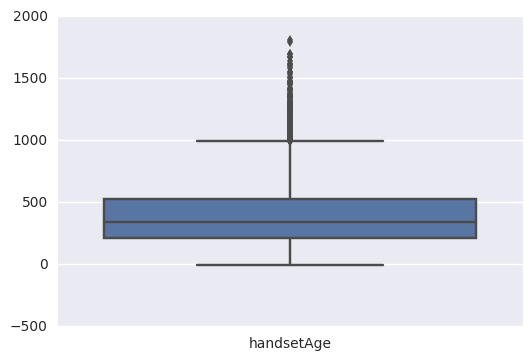

In [11]:
sns.boxplot(data=pd_df[["handsetAge"]])

In [214]:
handsetAge_Outliers_transformer = corr_Outliers(inputCol='handsetAge', outputCol='handsetAge_No_out', minfix=0)
pipeline_3 = Pipeline(stages=[handsetAge_Outliers_transformer])
model = pipeline_3.fit(raw_data_df)
newmodel3 = model.transform(raw_data_df)

In [215]:
newmodel3.describe("handsetAge").show()

+-------+------------------+
|summary|        handsetAge|
+-------+------------------+
|  count|             10000|
|   mean|          390.1717|
| stddev|257.07665638839256|
|    min|                -5|
|    max|              1812|
+-------+------------------+



In [216]:
newmodel3.describe("handsetAge_No_out").show()

+-------+-----------------+
|summary|handsetAge_No_out|
+-------+-----------------+
|  count|            10000|
|   mean|         385.6217|
| stddev|243.0541892726854|
|    min|              0.0|
|    max|            997.5|
+-------+-----------------+



marriageStatus 

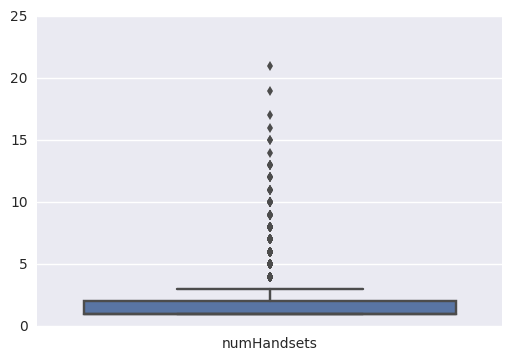

In [10]:
sns.boxplot(data=pd_df[["numHandsets"]])

In [219]:
numHandsets_Outliers_transformer = corr_Outliers(inputCol='numHandsets', outputCol='numHandsets_no_out', minfix=0)
pipeline_3 = Pipeline(stages=[numHandsets_Outliers_transformer])
model = pipeline_3.fit(raw_data_df)
newmodel3 = model.transform(raw_data_df)

In [220]:
newmodel3.describe("numHandsets").show()

+-------+------------------+
|summary|       numHandsets|
+-------+------------------+
|  count|             10000|
|   mean|            1.8045|
| stddev|1.3450876090677524|
|    min|                 1|
|    max|                21|
+-------+------------------+



In [221]:
newmodel3.describe("numHandsets_no_out").show()

+-------+------------------+
|summary|numHandsets_no_out|
+-------+------------------+
|  count|             10000|
|   mean|           1.66215|
| stddev|0.8636880068620382|
|    min|               1.0|
|    max|               3.5|
+-------+------------------+



regionType

In [228]:
class corr_regionType(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(corr_regionType, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        input_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: map_R_T_S_U(x), StringType())
        return dataset.withColumn(out_col, udf(input_col))

def dic(x):
    return {
        'unknown': 'u',
        '': 'u',
        'town': 't',
        't': 't',
        'suburban': 's',
        's': 's',
        'rural': 'r',
        'r': 'r'
    }[x]

def map_R_T_S_U(various):
    return dic(various)

In [227]:
newmodel3.select("regionType").distinct().rdd.collect()

[Row(regionType=u'unknown'),
 Row(regionType=u'suburban'),
 Row(regionType=u'town'),
 Row(regionType=u'rural'),
 Row(regionType=u'r'),
 Row(regionType=u''),
 Row(regionType=u't'),
 Row(regionType=u's')]

In [231]:
corr_regionType_transformer = corr_regionType(inputCol='regionType', outputCol='regionType_corr')
pipeline_3 = Pipeline(stages=[corr_regionType_transformer])
model = pipeline_3.fit(raw_data_df)
newmodel3 = model.transform(raw_data_df)

In [232]:
newmodel3.select("regionType_corr").distinct().rdd.collect()

[Row(regionType_corr=u'u'),
 Row(regionType_corr=u'r'),
 Row(regionType_corr=u't'),
 Row(regionType_corr=u's')]